##  Binary Classification using Perception, MLP and Autoencoder

#### Loading the required libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical

import matplotlib.pyplot as plt

Using TensorFlow backend.


#### Problem

    Is to identify products at risk of backorder before the event occurs so the business has time to react. 

#### Data

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product

    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.

#### Identify Right Error Metrics

    Based on the businees have to identify right error metrics.

#### Loading the data

In [2]:
import os
PATH = os.getcwd()

In [3]:
os.chdir(PATH)

In [4]:
data = pd.read_csv("BackOrders.csv",header=0)

#### Understand the Data

See the No. row and columns

In [5]:
data.shape

(61589, 23)

Display the columns

In [6]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

Display the index

In [7]:
data.index

RangeIndex(start=0, stop=61589, step=1)

See the top rows of the data

In [8]:
data[:3]

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No


Shows a quick statistic summary of your data using describe

In [9]:
data.describe(include='all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,6.158900e+04,61589.000000,58186.000000,61589.000000,6.158900e+04,6.158900e+04,6.158900e+04,61589.000000,61589.000000,6.158900e+04,...,61589.000000,61589.000000,61589.000000,61589.000000,61589,61589,61589,61589,61589,61589
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48145,61577,53792,59303,61569,50296
mean,2.037188e+06,287.721882,7.559619,30.192843,1.692728e+02,3.150413e+02,4.535760e+02,44.742957,150.732631,2.835465e+02,...,1.605400,-6.264182,-5.863664,1.205361,NaN,NaN,NaN,NaN,NaN,NaN
std,6.564178e+05,4233.906931,6.498952,792.869253,5.286742e+03,9.774362e+03,1.420201e+04,1373.805831,5224.959649,8.872270e+03,...,42.309229,25.537906,24.844514,29.981155,NaN,NaN,NaN,NaN,NaN,NaN
min,1.068628e+06,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,-99.000000,-99.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.498574e+06,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.620000,0.640000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.898033e+06,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000,4.000000e+00,...,0.000000,0.820000,0.800000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.314826e+06,57.000000,8.000000,0.000000,1.200000e+01,2.500000e+01,3.600000e+01,6.000000,17.000000,3.400000e+01,...,0.000000,0.960000,0.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


Display data type of each variable

In [10]:
data.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

#### Observations

    sku is Categorical but is interpreted as int64 
    potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are also categorical but is interpreted as object. 

#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [11]:
for col in ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data[col] = data[col].astype('category')

Display data type of each variable

In [12]:
data.dtypes

sku                  category
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

#### Delete sku attribute

In [13]:
np.size(np.unique(data.sku, return_counts=True)[0])

61589

In [14]:
data.drop('sku', axis=1, inplace=True)

#### Missing Data

    Missing value analysis and dropping the records with missing values

In [15]:
data.isnull().sum()

national_inv            0
lead_time            3403
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
went_on_backorder       0
dtype: int64

Observing the number of records before and after missing value records removal

In [16]:
print (data.shape)

(61589, 22)


In [17]:
#Since the number of missing values is about 5%. For initial analysis we ignore all these records
data = data.dropna(axis=0)

In [18]:
data.isnull().sum()
print(data.shape)

(58186, 22)


#### Converting Categorical to Numeric

For some of the models all the independent attribute should be of type numeric and Linear Regression model is one among them.
But this data set has some categorial attributes.

'pandas.get_dummies' To convert convert categorical variable into dummy/indicator variables


In [19]:
print (data.columns)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')


Creating dummy variables.

    If we have k levels in a category, then we create k-1 dummy variables as the last one would be redundant. So we use the parameter drop_first in pd.get_dummies function that drops the first level in each of the category


In [20]:
categorical_Attributes = data.select_dtypes(include=['category']).columns

In [21]:
data = pd.get_dummies(columns=categorical_Attributes, data=data, prefix=categorical_Attributes, prefix_sep="_",drop_first=True)

In [22]:
print (data.columns, data.shape)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes', 'went_on_backorder_Yes'],
      dtype='object') (58186, 22)


#### Target attribute distribution

In [23]:
pd.value_counts(data['went_on_backorder_Yes'].values)

0    47217
1    10969
dtype: int64

#### Split the data in to train and test

sklearn.model_selection.train_test_split

    Split arrays or matrices into random train and test subsets

In [24]:
#Performing train test split on the data
X, y = data.loc[:,data.columns!='went_on_backorder_Yes'].values, data.loc[:,'went_on_backorder_Yes'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


In [25]:
#To get the distribution in the target in train and test
print(pd.value_counts(y_train))
print(pd.value_counts(y_test))

0    33067
1     7663
dtype: int64
0    14150
1     3306
dtype: int64


#### Perceptron Model Building

In [26]:
perceptron_model = Sequential()

perceptron_model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid', kernel_initializer='normal'))

In [27]:
perceptron_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
perceptron_model.fit(X_train, y_train, epochs=30, batch_size=64)

Epoch 1/30
40730/40730 [==============================] - 1s 16us/step - loss: 0.4999 - acc: 0.8321
Epoch 2/30
40730/40730 [==============================] - 0s 11us/step - loss: 0.4173 - acc: 0.8475
Epoch 3/30
40730/40730 [==============================] - 0s 12us/step - loss: 0.4169 - acc: 0.8506
Epoch 4/30
40730/40730 [==============================] - 0s 12us/step - loss: 0.4224 - acc: 0.8559
Epoch 5/30
40730/40730 [==============================] - 0s 11us/step - loss: 0.4274 - acc: 0.8583
Epoch 6/30
40730/40730 [==============================] - 0s 11us/step - loss: 0.4114 - acc: 0.8576
Epoch 7/30
40730/40730 [==============================] - 0s 11us/step - loss: 0.4252 - acc: 0.8590
Epoch 8/30
40730/40730 [==============================] - 0s 11us/step - loss: 0.4610 - acc: 0.8587
Epoch 9/30
40730/40730 [==============================] - 0s 11us/step - loss: 0.4151 - acc: 0.8662
Epoch 10/30
40730/40730 [==============================] - 0s 11us/step - loss: 0.4207 - acc: 0.8646

#### Predictions

In [29]:
test_pred=perceptron_model.predict_classes(X_test)
train_pred=perceptron_model.predict_classes(X_train)

#### Getting evaluation metrics and evaluating model performance

In [30]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[31762  1305]
 [ 3899  3764]]
[[13579   571]
 [ 1707  1599]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [31]:
Accuracy_Train = (confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Train TNR:  0.9605346720295158
Train TPR:  0.49119143938405324
Train Accuracy:  0.8722317701939603


In [32]:
Accuracy_Test = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR:  0.9596466431095406
Test TPR:  0.48366606170598914
Test Accuracy:  0.8695004582951421


#### Plotting ROC curve to modify the threshold if necessary

1. Initially we have predicted the classes. This was easy because, by default the threshold was fixed at 0.5. Hence the probabilities got converted to 0 or 1 based on probability for that record
2. Now  the values of 0's and 1's itself are not sufficient to get the ROC curve. We need to have the probabilities.
3. We have a function called predict_proba that generates probalility for success which can be used for plotting ROC


In [33]:
train_pred_prob=perceptron_model.predict(X_train)

In [34]:
print (train_pred_prob)

[[1.1487173e-36]
 [7.5869697e-01]
 [4.5059481e-01]
 ...
 [4.3022853e-01]
 [4.8003800e-02]
 [2.4811320e-01]]


#### Getting ROC curve to adjust the threshold 

In [35]:
fpr, tpr, thresholds = roc_curve(y_train, train_pred_prob)
roc_auc = auc(fpr, tpr)

#### Using matplotlib for plotting the ROC curve 

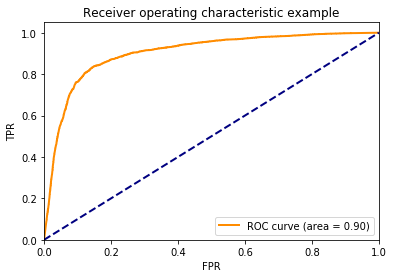

In [36]:
plt.figure()
lw = 2
plt.plot(fpr,tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### MLP Model Building

In [37]:
mlp_model = Sequential()

mlp_model.add(Dense(12, input_dim=X_train.shape[1], activation='relu', kernel_initializer='glorot_normal'))
mlp_model.add(Dense(8, activation='relu', kernel_initializer='normal'))
mlp_model.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [38]:
mlp_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
mlp_model.fit(X_train, y_train, epochs=30, batch_size=64)

Epoch 1/30
40730/40730 [==============================] - 1s 25us/step - loss: 0.3630 - acc: 0.8353: 0s - loss: 0.4295 - acc: 0.8 - ETA: 0s - loss: 0.4000 - acc:
Epoch 2/30
40730/40730 [==============================] - 1s 15us/step - loss: 0.2984 - acc: 0.8863
Epoch 3/30
40730/40730 [==============================] - 1s 16us/step - loss: 0.2863 - acc: 0.8908
Epoch 4/30
40730/40730 [==============================] - 1s 17us/step - loss: 0.2835 - acc: 0.8901
Epoch 5/30
40730/40730 [==============================] - 1s 17us/step - loss: 0.2729 - acc: 0.8919
Epoch 6/30
40730/40730 [==============================] - 1s 16us/step - loss: 0.2669 - acc: 0.8943
Epoch 7/30
40730/40730 [==============================] - 1s 16us/step - loss: 0.2590 - acc: 0.8967
Epoch 8/30
40730/40730 [==============================] - 1s 16us/step - loss: 0.2566 - acc: 0.8976
Epoch 9/30
40730/40730 [==============================] - 1s 16us/step - loss: 0.2532 - acc: 0.8987: 0s - loss: 0.2514 - acc
Epoch 10/30
4

#### Predictions

In [40]:
test_pred=mlp_model.predict_classes(X_test)
train_pred=mlp_model.predict_classes(X_train)

#### Getting evaluation metrics and evaluating model performance

In [41]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[31118  1949]
 [ 2041  5622]]
[[13331   819]
 [  884  2422]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [42]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Train TNR:  0.9410590619046179
Train TPR:  0.7336552264126321
Train Accuracy:  0.9020378099680825


In [43]:
Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR:  0.9421201413427562
Test TPR:  0.7326073805202662
Test Accuracy:  0.9024404216315307


#### Plotting ROC curve to modify the threshold if necessary

In [44]:
train_pred_prob=mlp_model.predict(X_train)

In [45]:
print (train_pred_prob)

[[2.8080029e-05]
 [9.5718485e-01]
 [7.2788608e-01]
 ...
 [3.2356027e-01]
 [2.0085916e-01]
 [1.2483378e-01]]


#### Getting ROC curve to adjust the threshold 

In [46]:
fpr, tpr, thresholds = roc_curve(y_train, train_pred_prob)
roc_auc = auc(fpr, tpr)

#### Using matplotlib for plotting the ROC curve 

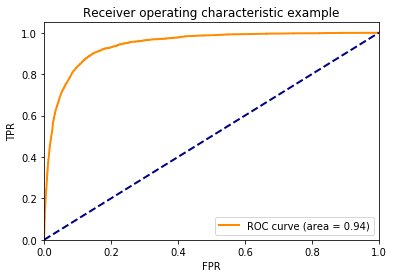

In [47]:
plt.figure()
lw = 2
plt.plot(fpr,tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Derive new non-linear features using autoencoder

In [49]:
# The size of encoded and actual representations
encoding_dim = 16 
actual_dim = X_train.shape[1]

In [50]:
# Input placeholder
input_img = Input(shape=(actual_dim,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(actual_dim, activation='relu')(encoded)

In [51]:
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [52]:
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                352       
_________________________________________________________________
dense_6 (Dense)              (None, 21)                357       
Total params: 709
Trainable params: 709
Non-trainable params: 0
_________________________________________________________________
None


In [53]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [54]:
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32)

Epoch 1/100
40730/40730 [==============================] - 1s 31us/step - loss: 526.3671: 1s -
Epoch 2/100
40730/40730 [==============================] - 1s 26us/step - loss: -859.3355
Epoch 3/100
40730/40730 [==============================] - 1s 26us/step - loss: -968.8141
Epoch 4/100
40730/40730 [==============================] - 1s 26us/step - loss: -974.9170
Epoch 5/100
40730/40730 [==============================] - 1s 26us/step - loss: -979.0020
Epoch 6/100
40730/40730 [==============================] - 1s 26us/step - loss: -981.3996
Epoch 7/100
40730/40730 [==============================] - 1s 26us/step - loss: -982.1283
Epoch 8/100
40730/40730 [==============================] - 1s 28us/step - loss: -982.3734
Epoch 9/100
40730/40730 [==============================] - 1s 28us/step - loss: -982.5048
Epoch 10/100
40730/40730 [==============================] - 1s 28us/step - loss: -982.5511
Epoch 11/100
40730/40730 [==============================] - 1s 27us/step - loss: -982.9491
Epo

40730/40730 [==============================] - 1s 27us/step - loss: -1030.4380
Epoch 90/100
40730/40730 [==============================] - 1s 27us/step - loss: -1030.3559
Epoch 91/100
40730/40730 [==============================] - 1s 27us/step - loss: -1027.8454
Epoch 92/100
40730/40730 [==============================] - 1s 26us/step - loss: -1030.5369
Epoch 93/100
40730/40730 [==============================] - 1s 27us/step - loss: -1030.5649
Epoch 94/100
40730/40730 [==============================] - 1s 27us/step - loss: -1030.5099
Epoch 95/100
40730/40730 [==============================] - 1s 27us/step - loss: -1030.4234
Epoch 96/100
40730/40730 [==============================] - 1s 28us/step - loss: -1030.4555
Epoch 97/100
40730/40730 [==============================] - 1s 27us/step - loss: -1030.5013
Epoch 98/100
40730/40730 [==============================] - 1s 27us/step - loss: -1027.8815
Epoch 99/100
40730/40730 [==============================] - 1s 27us/step - loss: -1027.9253
E

Create a separate encoder model

In [55]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [56]:
print(encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                352       
Total params: 352
Trainable params: 352
Non-trainable params: 0
_________________________________________________________________
None


#### derive new non-linear features

In [57]:
X_train_nonLinear_features = encoder.predict(X_train)
X_test_nonLinear_features = encoder.predict(X_test)

#### Combining new non-linear features to X_train and X_test respectively

In [58]:
X_train=np.concatenate((X_train, X_train_nonLinear_features), axis=1)
X_test=np.concatenate((X_test, X_test_nonLinear_features), axis=1)

#### Perceptron Model Building with both actual and non-linear features

In [59]:
perceptron_model = Sequential()

perceptron_model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid', kernel_initializer='normal'))

In [60]:
perceptron_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
perceptron_model.fit(X_train, y_train, epochs=30, batch_size=64)

Epoch 1/30
40730/40730 [==============================] - 1s 16us/step - loss: 0.5578 - acc: 0.8413
Epoch 2/30
40730/40730 [==============================] - 0s 12us/step - loss: 0.4403 - acc: 0.8651
Epoch 3/30
40730/40730 [==============================] - 0s 11us/step - loss: 0.4176 - acc: 0.8804
Epoch 4/30
40730/40730 [==============================] - 0s 11us/step - loss: 0.4163 - acc: 0.8863
Epoch 5/30
40730/40730 [==============================] - 0s 12us/step - loss: 0.4301 - acc: 0.8843
Epoch 6/30
40730/40730 [==============================] - 1s 12us/step - loss: 0.3915 - acc: 0.8907
Epoch 7/30
40730/40730 [==============================] - 0s 12us/step - loss: 0.4357 - acc: 0.8841
Epoch 8/30
40730/40730 [==============================] - 0s 12us/step - loss: 0.3887 - acc: 0.8919
Epoch 9/30
40730/40730 [==============================] - 0s 12us/step - loss: 0.4364 - acc: 0.8846
Epoch 10/30
40730/40730 [==============================] - 0s 11us/step - loss: 0.4264 - acc: 0.8890

#### Predictions

In [62]:
test_pred=perceptron_model.predict_classes(X_test)
train_pred=perceptron_model.predict_classes(X_train)

#### Getting evaluation metrics and evaluating model performance

In [63]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[31121  1946]
 [ 2294  5369]]
[[13330   820]
 [  970  2336]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [64]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Train TNR:  0.9411497867965041
Train TPR:  0.7006394362521206
Train Accuracy:  0.8958998281365087


In [65]:
Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR:  0.9420494699646643
Test TPR:  0.7065940713853599
Test Accuracy:  0.8974564619615032


#### Plotting ROC curve to modify the threshold if necessary

In [66]:
train_pred_prob=perceptron_model.predict(X_train)

In [67]:
print (train_pred_prob)

[[0.        ]
 [0.94360936]
 [0.61789525]
 ...
 [0.4330393 ]
 [0.01081788]
 [0.31793812]]


#### Getting ROC curve to adjust the threshold 

In [68]:
fpr, tpr, thresholds = roc_curve(y_train, train_pred_prob)
roc_auc = auc(fpr, tpr)

#### Using matplotlib for plotting the ROC curve 

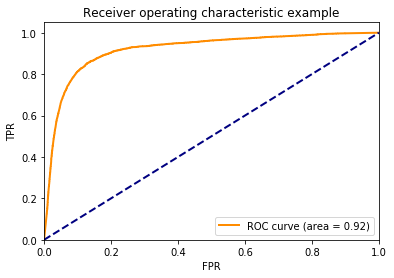

In [69]:
plt.figure()
lw = 2
plt.plot(fpr,tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()